# Multiclass Classification
In this notebook, the popularity prediction task is approached as a multiclass classification problem, with each video being assigned one of three popularity classes according to its view count

In [1]:
%cd ..

C:\Users\georg\Documents\msc-project


In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.evaluation import compare_models
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn import neighbors,svm, ensemble, linear_model, dummy
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import ADASYN
from imblearn.pipeline import make_pipeline

In [3]:
df = pd.read_csv("data/interim/tracks.csv")

The views are split into 3 popularity bins according to the histogram presented in the "Exploration" notebook

In [4]:
popularity_bins = [0,5e+04,1e+06,1e+09]
features = [
    'danceability',
    'energy',
    'key',
    'loudness',
    'mode',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    'time_signature',
    'duration_ms'
]

views = df['views']
data = df.loc[views > 0,features]
targets = views[views > 0].apply(np.digitize,bins=popularity_bins)

X, y = data, targets

Text(0, 0.5, 'Video count')

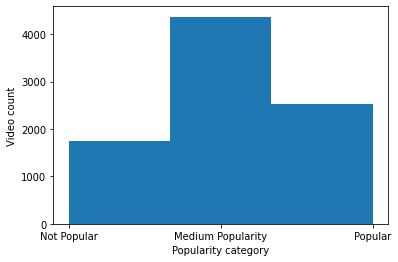

In [5]:
y.hist(bins=3, grid=False)
plt.xticks([1,2,3], labels=["Not Popular","Medium Popularity","Popular"])
plt.xlabel("Popularity category")
plt.ylabel("Video count")

In [52]:
models = [
    ("Baseline",dummy.DummyClassifier(strategy='stratified')),
    ("5-KNN",neighbors.KNeighborsClassifier(n_neighbors=5)),
    ("10-KNN",neighbors.KNeighborsClassifier(n_neighbors=10)),
    ("SVM Linear", svm.SVC(kernel='linear')),
    ("SVM RBF", svm.SVC(kernel='rbf')),
    ("Random Forest",ensemble.RandomForestClassifier()),
    ("Logistic Regression",linear_model.LogisticRegression())
]
oversampled_models = []
for name, model in models:
    combined = make_pipeline(
        ADASYN(),
        model
    )
    oversampled_models.append((name,combined))
    
metrics = {
    'precision': make_scorer(precision_score,average='macro',zero_division=0),
    'recall': 'recall_macro',
    'f1': 'f1_macro'
}
compare_models(oversampled_models,metrics, data, targets)

Evaluating Baseline
Evaluating 5-KNN
Evaluating 10-KNN
Evaluating SVM Linear
Evaluating SVM RBF
Evaluating Random Forest
Evaluating Logistic Regression


,model,fit_time,score_time,test_precision,test_recall,test_f1
0,Baseline,0.615647,0.004558,0.329883,0.330677,0.317350
1,5-KNN,0.642605,0.350678,0.352040,0.353282,0.329507
2,10-KNN,0.671989,0.426154,0.354234,0.356824,0.324539
3,SVM Linear,9.171703,0.397397,0.267932,0.350681,0.219490
4,SVM RBF,7.553114,1.719624,0.348199,0.353268,0.313095
5,Random Forest,3.193863,0.049494,0.350793,0.350839,0.350440
6,Logistic Regression,0.668049,0.004171,0.345501,0.349758,0.287705


The most promising model in terms of precision and recall is the RBF kernel SVM. Using a confusion matrix will provide more insight into the performance of the model.

In [57]:
X_train, X_test, y_train,y_test = train_test_split(data, targets)
X_train, y_train = ADASYN().fit_resample(X_train,y_train)
model = ensemble.RandomForestClassifier()
model.fit(X_train,y_train)
predicted = model.predict(X_test)

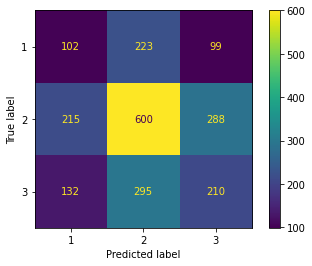

In [58]:
ConfusionMatrixDisplay.from_predictions(y_test,predicted)

In [33]:
predicted

array([2, 2, 2, ..., 2, 2, 2], dtype=int64)